# Data Mining and Machine Learning - Text classification - Tissot

The goal of this project was to create a model from data with texts that have a label difficulty in order to predict the difficulty level of any french text. This is used to help english speaking people that are learning french to find an appropriate text to practise reading.





This notebook was made for the DMML 2021 course. all the information on this project can be found on the publicly available github by clicking on this link:

https://github.com/ABonvin/DMML21_Tissot/

This was also a Kaggle competition:

https://www.kaggle.com/c/detecting-the-difficulty-level-of-french-texts/overview

Team Participants:

- Arnaud Bonvin
- Vakisan Tharmakulasinkam
- Tarald Dysthe



### 1. Read data into your notebook. 


In [1]:
import os
import sys
import get_dataset
import pandas as pd
import numpy as np
import numpy
import csv
from tqdm import tqdm

from functs import evaluate, get_score
from keras_funct import *

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow import keras


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import spacy as spacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc
import fr_core_news_md
from gensim.models import word2vec

from IPython.display import YouTubeVideo


np.random.seed = 0


In [2]:
df = get_dataset.get_train_data()
scores=[]
matrixes=[]



Here is the look of the dataframe you will use for the project


In [3]:
df.head()

,sentence,difficulty
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1


Have a look at the data on which to make predictions.

In [4]:
df_pred = get_dataset.get_unlabelled_data()
df_pred.head()

,sentence
0,Nous dûmes nous excuser des propos que nous eû...
1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,"Et, paradoxalement, boire froid n'est pas la b..."
3,"Ce n'est pas étonnant, car c'est une saison my..."
4,"Le corps de Golo lui-même, d'une essence aussi..."


And this is the format for your submissions.

In [5]:
df_example_submission = get_dataset.get_sub_data()

df_example_submission.head()

,difficulty
0,A1
1,A1
2,A1
3,A1
4,A1


### 2. Train your models

Set your X and y variables. 
Set the `random_state=0`
Split the data into a train and test set using the following parameters `train_test_split(X, y, test_size=0.2, random_state=0)`.

#### 2.1.Baseline
What is the baseline for this classification problem? (you can use the highest label frequency from the entire training data, the df above)

In [6]:
pred = df.groupby('difficulty').count()
baseline_accuracy = pred['sentence'].max()/len(df)
print(f'The baseline accuracy is {round(baseline_accuracy*100,2)}%')

The baseline accuracy is 16.94%


#### 2.2. Logistic Regression (without data cleaning)

Train a simple logistic regression model using a Tfidf vectoriser.

In [7]:
corpus = df['sentence'].tolist()

X_train, X_test, y_train, y_test = train_test_split(corpus, df['difficulty'].tolist(),
                                                    test_size = 0.2,
                                                    random_state = 0)

In [8]:
pipe = Pipeline([('tfidf', TfidfVectorizer()), ('log_reg', LogisticRegression())])
pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)

Calculate accuracy, precision, recall and F1 score on the test set.

AxesSubplot(0.125,0.125;0.62x0.755)
ACCURACY SCORE:
0.4667
CLASSIFICATION REPORT:
	Precision: 0.4645
	Recall: 0.4677
	F1_Score: 0.4640


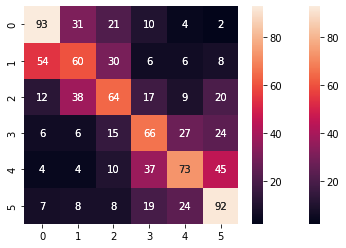

In [9]:
evaluate(y_test, pred)
score, matrix = get_score(y_test, pred, "Logisitc Regression")

scores.append(score)
matrixes.append(matrixes)

Have a look at the confusion matrix and identify a few examples of sentences that are not well classified.

In [10]:
examples=pd.DataFrame(X_test, columns=["sentence"])
examples["true"]=y_test
examples["pred"]=pred
examples = examples[examples["true"] != examples["pred"]]

examples.head()


,sentence,true,pred
0,"C'est en décembre 1967, après bien des invecti...",C1,C2
1,Giscard va pourtant réussir à transformer ce r...,C1,B2
2,Un choix difficile mais important : le public ...,A2,B1
3,Le débat porte plutôt sur l'utilité d'une tell...,B1,C1
6,Il faut du temps et du courage pour soigner to...,A2,B1


Generate your first predictions on the `unlabelled_test_data.csv`. make sure your predictions match the format of the `unlabelled_test_data.csv`.

In [11]:
unlabelled = get_dataset.get_unlabelled_data()
pred = pipe.predict(unlabelled['sentence'].tolist())

log_reg = pd.DataFrame(pred, columns=['difficulty'])
log_reg=log_reg.rename_axis("id", inplace=False)
log_reg.to_csv('log_reg_pred.csv')

#### 2.3. KNN (without data cleaning)

Train a KNN classification model using a Tfidf vectoriser. Show the accuracy, precision, recall and F1 score on the test set.

AxesSubplot(0.125,0.125;0.62x0.755)
ACCURACY SCORE:
0.3187
CLASSIFICATION REPORT:
	Precision: 0.4007
	Recall: 0.3183
	F1_Score: 0.3022


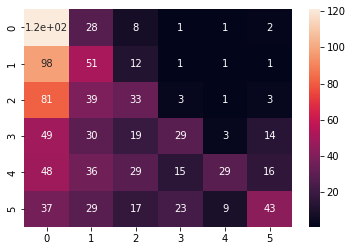

In [12]:
KNN = KNeighborsClassifier()
pipe = Pipeline([('tfidf', TfidfVectorizer()), ('KNN', KNN)])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
evaluate(y_test, pred)


Try to improve it by tuning the hyper parameters (`n_neighbors`,   `p`, `weights`).

Best hyperparameters: {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
AxesSubplot(0.125,0.125;0.62x0.755)
ACCURACY SCORE:
0.3542
CLASSIFICATION REPORT:
	Precision: 0.4197
	Recall: 0.3543
	F1_Score: 0.3450


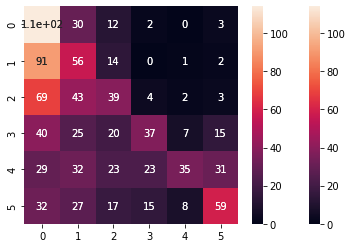

In [13]:
knn_grid = {'n_neighbors' : np.arange(1,500,5),
            'p': np.arange(1,3),
            'weights' : ['uniform', 'distance']}

KNN = KNeighborsClassifier()
KNN_CV = GridSearchCV(KNN, knn_grid, cv = 5)
pipe = Pipeline([('tfidf', TfidfVectorizer()), ('KNN', KNN_CV)])

pipe.fit(X_train, y_train)
print('Best hyperparameters:', KNN_CV.best_params_)
pred = pipe.predict(X_test)


evaluate(y_test, pred)
score, matrix = get_score(y_test, pred, "KNN")

scores.append(score)
matrixes.append(matrixes)

#### 2.4. Decision Tree Classifier (without data cleaning)

Train a Decison Tree classifier, using a Tfidf vectoriser. Show the accuracy, precision, recall and F1 score on the test set.

AxesSubplot(0.125,0.125;0.62x0.755)
ACCURACY SCORE:
0.2948
CLASSIFICATION REPORT:
	Precision: 0.2983
	Recall: 0.2945
	F1_Score: 0.2933


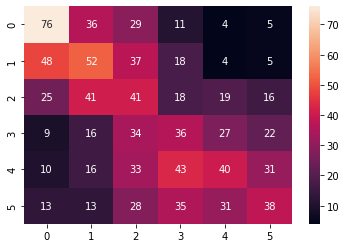

In [14]:
pipe = Pipeline([('tfidf', TfidfVectorizer()), ('decision_tree', DecisionTreeClassifier())])
pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
evaluate(y_test, pred)

Try to improve it by tuning the hyper parameters (`max_depth`, the depth of the decision tree).

Hyperparameters: {'max_depth': 805}
AxesSubplot(0.125,0.125;0.62x0.755)
ACCURACY SCORE:
0.3125
CLASSIFICATION REPORT:
	Precision: 0.3121
	Recall: 0.3130
	F1_Score: 0.3095


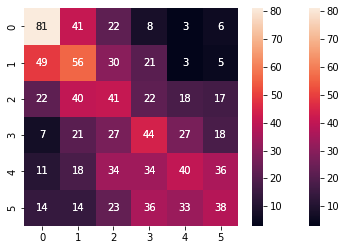

In [15]:
grid_tree = {'max_depth': np.arange(5,1000, 50)}

dec_tree = DecisionTreeClassifier()
dec_tree_CV = GridSearchCV(dec_tree, grid_tree, cv = 5)
pipe = Pipeline([('tfidf', TfidfVectorizer()), ('decision_tree_CV', dec_tree_CV)])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print("Hyperparameters:", dec_tree_CV.best_params_)
evaluate(y_test, pred)

score, matrix = get_score(y_test, pred, "Decision Tree")

scores.append(score)
matrixes.append(matrixes)

#### 2.5. Random Forest Classifier (without data cleaning)

Try a Random Forest Classifier, using a Tfidf vectoriser. Show the accuracy, precision, recall and F1 score on the test set.

AxesSubplot(0.125,0.125;0.62x0.755)
ACCURACY SCORE:
0.4260
CLASSIFICATION REPORT:
	Precision: 0.4327
	Recall: 0.4284
	F1_Score: 0.4147


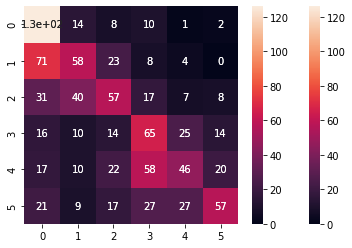

In [16]:
random_forest_classifier = RandomForestClassifier()
pipe = Pipeline([('tfidf', TfidfVectorizer()), ('random_forest_clf', random_forest_classifier)])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
evaluate(y_test, pred)

score, matrix = get_score(y_test, pred, "Random Forest")

scores.append(score)
matrixes.append(matrixes)

#### 2.6. Any other technique, including data cleaning if necessary

Try to improve accuracy by training a better model using the techniques seen in class, or combinations of them.

As usual, show the accuracy, precision, recall and f1 score on the test set.

----------------------------------------------------------------------------------------------------------------

The classifier we chose for this challenge is the Keras neural classifier from the Keras library. While begin extremely powerful and evolutive, this classifier is using the keras API which is a very high level deep learning API and a good entry point for newbies in the field (very much like us). We did not have time to dig too deep into this API but we managed to get some pretty good results from this classifier.

Our classifier uses layers of neurons in a sequential fashion. This basically help us break down a very complex math problem (the classification of difficulties) into smaller equations to be able to process it. We used only a single layer of neurons which gave us the best predicitons.


The first thing we have to do is to import all of the data from the train set.

In [17]:
data = get_dataset.get_train_data()

Now we create the features of our classifier. Those are the following:

--------------------------------------------------------------------------------------------------------------------------

**type_counter(data)**

This feature counts the number of occurences of each type of word in a given sentence (nouns, pronouns, ...) and assigns it the difficulty of the sentence.

---------------------------------------------------------------------------------------------------------------------------

**vectorizer(data)**

This is a spacy vectorizer which tokenizes each sentence and creates a vectorized representation of those tokens. This vectorizer is more precise than the sk_vec and has more features

---------------------------------------------------------------------------------------------------------------------------

**sk_vec(data)**

This is the sklearn vectorizer. It transforms words into simple vectors. We alos used this vectorizer to process bi-grams

---------------------------------------------------------------------------------------------------------------------------

**word_len_counter(data)**

This features is a counter of length for both words and sentences. We assume that simpler sentences are usually shorter while longer phrases are usually way longer and have longer words.

---------------------------------------------------------------------------------------------------------------------------




We also use several other functions which are:

**prepare_output(data)**

This function process the input data and transforms it into usable data for the classifier (mapping the difficulties into either a label encoding or a 1-hot-encoding)

----------------------------------------------------------------------------------------------------------------------------


**get_score(true, pred, classifier_name)**

Just so we can create a table with all the results (see code for more info)

----------------------------------------------------------------------------------------------------------------------------


We also used a filter we found on stackoverflow (**remove_tokens_on_match(doc)**) to remove specific types of words from our data. After manual observation on the badly predicted sentences, we saw that a lot of B2 sentences were wrong compared to other difficulties, but also that a lot of sentences with proper nouns we not predicted correctly. We filtered both the punctuation and the proper nouns from our dataset, and the issue resolved itslef (there were approximatly 30% more B2 phrases that were badly estimated before we used the filter)

After all the testing, we lastly implemented the bigram feature, which increased our accuracy by nearly 10%. Bigger Ngrams were ineffective and even decreased precision

Those features were all matrixes in a shape of  N x Number of sentences, with N varying for each feature.

Since those features all have the same column length, we are able to aggregate them into one feature to pass it to the classifier.

*More info on all the fucntions can be found in the .py corresponding file*


**Important notes:**

- We did not remove stopwords because sentences were sometimes too short (especially A1 sentences). We tested it and accuracy was always marginally lower
- We tried a number of features combination but the best results were always the full combination of the 4 features implemented.
- Since the processing of those models is rather power hungry in terms of ressources, we could not test the full potential of the model. All the testing was done manually when it came to hyperparamters.
- The features for our model are not well fitted to be used with the other classifiers.
- We sometimes use "unlabelled" functions. Those are relevant for the final prediction because we use 2 different dataset (one for fitting and one for predicting) and not a single one splitted into 2 to fit and transform.


In [18]:
feature1 = type_counter(data)
print("Feature 1 is done computing")
feature2 = vectorizer(data)
print("Feature 2 is done computing")
feature3 = word_len_counter(data)
print("Feature 3 is done computing")
feature4 = sk_vec(data)
print("Feature 4 is done computing")
feature = np.concatenate((feature1, feature2),axis = 1)
feature = np.concatenate((feature, feature3), axis = 1)
feature = np.concatenate((feature, feature4), axis = 1)

print("Features ready to be used")

Feature 1 is done computing
Feature 2 is done computing
Feature 3 is done computing
Feature 4 is done computing
Features ready to be used


In [19]:
y1, y2 = prepare_output(data)
print("Data ready to be used")

Data ready to be used


In [20]:
#X_train
feature_train = np.array(feature[:4000])

#y_train
y2_train = np.asarray(y2[:4000])
y1_train = np.asarray(y1[:4000])

#X_test
feature_test = np.array(feature[4000:])

#y_test
y2_test = np.asarray(y2[4000:])
y1_test = np.asarray(y1[4000:])

print("Data has been split")

Data has been split


The sequential model from keras is made of linear stacks of layers of neurons connected to eachother by what are called snyapses. Neurons receive inputs, then compute the input into an output and transmit the output to another neuron through the synapse.  Those synapses each have a weight, which represents it's impact on the final computation of the input. Basically, if you input data to those neurons layers, they will break down an extensive and complicated input into a simpler output.

We only use basic keras layers which are the Dense layers (standards neural layers) and the dropout layers (they deactivate a percentage of the synapses to prevent overfit). Each layer must be defined by a number of neurons (units) and an activator (

To create a model, we have to specify the input shape of the data (only on the first layer), the number of neurons in the layer and the activator (takes the output and convert it into a form that is readable by the next layer). With this, each neuron will have it's own activation function. Activation functions are very important because it lets the classifier produce a nonlinear decision boundary. Linear decision boundaries would be much less precise and are useless in this kind of decisions.

To fit the model, we also have to set an optimizer (we use Adamax, basically a gradient descent) and a loss function.

The outpout of our model is formed based on the probability of each sentence begin in class.
For example, if my model outputs those prababilites :[0.1, 0.1, 0.2, 0.5], it means that my sentence has a 10% chance to be in the class 0, 10% chance to be in the class 1, 20% chance to be in the class and 50% chance to be in the class 0. This means we have to get the highest probable class and keep it as the predicted class for the sentence.

Then, just so we can read the data, we have to convert it back from label to difficulties. with:

*reverse={0:"A1", 1:"A2", 2:"B1",3:"B2",4:"C1", 5:"C2"}*

Please note that the result will vary each time the sequential model is ran. There will be some differences with the final look of the table.

In [21]:
model = keras.Sequential([
    keras.layers.Dense(input_shape = feature_train[0].shape, units=32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=6, activation='softmax')
    
])

print(model.summary())
model.compile(optimizer='adamax', 
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
model.fit(np.asarray(feature_train), np.asarray(y2_train), epochs = 75, steps_per_epoch = 500, validation_split=0.01)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                2171264   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 2,171,462
Trainable params: 2,171,462
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/75
500/500 [==============================] - 5s 7ms/step - loss: 1.5477 - accuracy: 0.3185 - val_loss: 1.3658 - val_accuracy: 0.5000
Epoch 2/75
500/500 [==============================] - 4s 7ms/step - loss: 1.4347 - accuracy: 0.3602 - val_loss: 1.2809 - val_accuracy: 0.4750
Epoch 3/75
500/500 [=

AxesSubplot(0.125,0.125;0.62x0.755)
ACCURACY SCORE:
0.5075
CLASSIFICATION REPORT:
	Precision: 0.5147
	Recall: 0.5125
	F1_Score: 0.5064


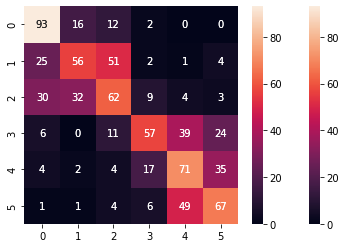

In [23]:
pred_train=model.predict(feature_test)
prediction_keras_train= []

for i in pred_train:
    prediction_keras_train.append(np.argmax(i))
reverse={0:"A1", 1:"A2", 2:"B1",3:"B2",4:"C1", 5:"C2"}
reversed_list_train=[reverse[k] for k in prediction_keras_train]

evaluate(y1_test, prediction_keras_train)
score, matrix = get_score(y1_test, prediction_keras_train, "Keras Sequential")

scores.append(score)
matrixes.append(matrixes)

Now we can apply evertyhing onto the unlabelled dataset and create a .csv submission for kaggle.

In [24]:
unlabelled = get_dataset.get_unlabelled_data()

unlabelled_feature1=type_counter_unlabelled(data, unlabelled)
print("Feature 1 is done computing")
unlabelled_feature2=vectorizer(unlabelled)
print("Feature 2 is done computing")
unlabelled_feature3=word_len_counter(unlabelled)
print("Feature 3 is done computing")
unlabelled_feature4=sk_vec_unlabelled(data,unlabelled)
print("Feature 3 is done computing")

unlabelled_feature = np.concatenate((unlabelled_feature1, unlabelled_feature2),axis = 1)
unlabelled_feature = np.concatenate((unlabelled_feature, unlabelled_feature3), axis = 1)
unlabelled_feature = np.concatenate((unlabelled_feature, unlabelled_feature4), axis = 1)
print("Features ready to be used")

Feature 1 is done computing
Feature 2 is done computing
Feature 3 is done computing
Feature 3 is done computing
Features ready to be used


In [25]:
model = keras.Sequential([
    keras.layers.Dense(input_shape = feature[0].shape, units=32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=6, activation='softmax'),

 
])
print(model.summary())
model.compile(optimizer='adamax', 
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
model.fit(np.asarray(feature), np.asarray(y2), epochs = 75, steps_per_epoch = 500, validation_split=0.01)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                2171264   
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 198       
                                                                 
Total params: 2,171,462
Trainable params: 2,171,462
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/75
500/500 [==============================] - 4s 7ms/step - loss: 1.5509 - accuracy: 0.3243 - val_loss: 1.4326 - val_accuracy: 0.3542
Epoch 2/75
500/500 [==============================] - 4s 7ms/step - loss: 1.4442 - accuracy: 0.3800 - val_loss: 1.3792 - val_accuracy: 0.4167
Epoch 3/75
500/500 

In [26]:

pred=model.predict(unlabelled_feature)
prediction_keras= []
for i in pred:
    prediction_keras.append(np.argmax(i))


reverse={0:"A1", 1:"A2", 2:"B1",3:"B2",4:"C1", 5:"C2"}

reversed_list=[reverse[k] for k in prediction_keras]
print(reversed_list)


['C2', 'B1', 'A1', 'A1', 'C2', 'C2', 'A2', 'A2', 'C2', 'A1', 'A1', 'A2', 'B2', 'C1', 'A1', 'A2', 'C1', 'A1', 'B1', 'A1', 'C2', 'A1', 'A2', 'C2', 'B2', 'C2', 'A1', 'A1', 'C2', 'A2', 'A1', 'A2', 'A2', 'A1', 'A2', 'B1', 'C1', 'B2', 'A1', 'A1', 'A2', 'B2', 'C2', 'C1', 'C2', 'C2', 'B2', 'C2', 'A1', 'A1', 'C1', 'A1', 'C1', 'A1', 'A1', 'B2', 'C1', 'A2', 'B2', 'B1', 'B2', 'A2', 'C2', 'C1', 'C2', 'B2', 'B1', 'A2', 'B2', 'C2', 'A1', 'C1', 'B2', 'B1', 'C1', 'A2', 'B2', 'C1', 'A2', 'B2', 'A2', 'A1', 'C2', 'B1', 'A1', 'C2', 'B1', 'C2', 'C2', 'B1', 'C2', 'A2', 'C1', 'C2', 'B1', 'A2', 'A1', 'A2', 'B1', 'C2', 'B1', 'C1', 'A1', 'A2', 'C2', 'C2', 'B2', 'A1', 'A2', 'C1', 'B2', 'A1', 'C1', 'B2', 'C2', 'A2', 'C1', 'A2', 'A2', 'B2', 'A1', 'B1', 'C2', 'C2', 'A2', 'C2', 'C2', 'C2', 'C1', 'C1', 'A1', 'A2', 'C1', 'C2', 'B2', 'C2', 'A2', 'C2', 'B1', 'A2', 'A1', 'C2', 'C2', 'C2', 'C1', 'C1', 'A1', 'C2', 'C2', 'B1', 'B2', 'B1', 'A1', 'A2', 'A2', 'C2', 'C1', 'A1', 'A1', 'A2', 'A2', 'A1', 'B1', 'B2', 'C2', 'C2', 'A1

In [29]:
keras_submission = pd.DataFrame()
keras_submission["difficulty"]=reversed_list
keras_submission=keras_submission.rename_axis("id", inplace=False)

keras_submission.to_csv('keras_submission.csv')


#### 4.7. Show a summary of your results

Here is the aggregated table for the classifiers results (also available on GitHub). Our classifier is by far the best of all the classifiers we tried.

## The final Kaagle submission score was 5.6250

In [28]:
table = pd.DataFrame(scores, columns=["Classifier", "Precision", "Recall", "F1- score", "Accuracy"])
table=table.set_index('Classifier')
table.head()

,Precision,Recall,F1- score,Accuracy
Classifier,,,,
Logisitc Regression,0.464496,0.467678,0.464014,0.466667
KNN,0.419700,0.354327,0.345031,0.354167
Decision Tree,0.312084,0.313016,0.309467,0.312500
Random Forest,0.432717,0.428427,0.414716,0.426042
Keras Sequential,0.514736,0.512527,0.506443,0.507500


In [4]:
YouTubeVideo('lFMVf7B4Zbo')